In [6]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

In [7]:
#讀取文件檔
path = os.path.abspath('training.txt')

In [8]:
#定義參數
maxlen = 0  #句子最大长度
word_freqs = collections.Counter()  #词频
num_recs = 0 # 样本数
ftrain = open(path,'rb') #用二進位的方式讀入，後面在下語法處理時要注意文字的data type

In [9]:
#計算句子最多有幾個單字
#以及計算有幾種word在裡面
for line in ftrain:
    label, sentence = line.strip().split(bytes('\t', encoding='utf8'))
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
        num_recs += 1
ftrain.close()
print('max_len ',maxlen)
print('nb_words ', len(word_freqs))

max_len  42
nb_words  2313


In [10]:
#定義最大的單字數與句子長度
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

In [11]:
#定義每個word的index
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [12]:
word2index['cool'] #word 對應 index

174

In [13]:
index2word[155] #index 對應 word

'watching'

In [14]:
#將文字拆解成每個token，存到x的list裡面
#將相對應的label取出，存到y裡面
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open(path, 'rb')
for line in ftrain:
    label, sentence = line.strip().split(bytes('\t', encoding='utf8'))
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    seqs = []
    for word in words:
        if word in word2index.keys():
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
        X[i] = seqs
        y[i] = int(str(label, encoding='utf8')[-1])
        i += 1
ftrain.close()

In [15]:
# 每個句子都轉變成相對應的Index
seqs

[90, 3, 6, 11, 13, 19, 18, 87, 26, 4]

In [16]:
X

array([list([5, 10, 9, 12, 101, 17, 48, 22, 4]),
       list([5, 10, 9, 12, 101, 17, 48, 22, 4]),
       list([5, 10, 9, 12, 101, 17, 48, 22, 4]), ...,
       list([90, 3, 6, 11, 13, 19, 18, 87, 26, 4]),
       list([90, 3, 6, 11, 13, 19, 18, 87, 26, 4]),
       list([90, 3, 6, 11, 13, 19, 18, 87, 26, 4])], dtype=object)

In [17]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [18]:
#將每個List 中的index 轉成相同長度的向量
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [19]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   5,  10,   9,  12, 101,  17,  48,  22,
         4])

In [20]:
#拆解成訓練集與測試集
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
EMBEDDING_SIZE = 128 #文字embedding 的向量大小
HIDDEN_LAYER_SIZE = 64 #LSTM中間的Layer要幾層
BATCH_SIZE = 32 #Batch size大小
NUM_EPOCHS = 1 #整個資料要train幾次
model = Sequential() #宣告model
#加入word 的Embedding(特徵數，向量長度，輸入層向量的長度)
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH)) 
model.add(SpatialDropout1D(0.2)) #資料投入後dropout input
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2)) #宣告LSTM層
model.add(Dense(1)) #輸出的結果向量數
model.add(Activation("sigmoid")) #經過sigmoid來轉變數字
#開始架構模型，定義loss與optimizer
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"]) 
#訓練模型
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))

Train on 72235 samples, validate on 18059 samples
Epoch 1/1
72235/72235 [==============================] - 131s 2ms/step - loss: 0.0244 - acc: 0.9903 - val_loss: 9.3556e-04 - val_acc: 0.9997


In [22]:
#看訓練的結果
history.history

{'acc': [0.9903232505018343],
 'loss': [0.024391198575474327],
 'val_acc': [0.9996677556896838],
 'val_loss': [0.0009355595622753185]}

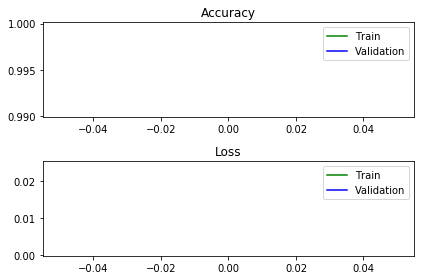

In [23]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [24]:
#測試模型的成效
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0ft%dt%s" % (ypred, ylabel, sent))

18059/18059 [==============================] - 7s 382us/step
Test score: 0.001, accuracy: 1.000
1t1ti am going to start reading the harry potter series again because that is one awesome story .
0t0tbrokeback mountain was boring .
0t0ti had to go to work at 9am for stupid mission impossible 3 .
0t0tda vinci code sucks .
0t0tthe da vinci code sucked big time .


In [25]:
predict_sentence = 'I like this movie.'

In [26]:
predict_word = nltk.word_tokenize(predict_sentence)
predict_word

['I', 'like', 'this', 'movie', '.']

In [27]:
predict_seq = []
for word in predict_word:
    if word in word2index.keys():
        predict_seq.append(word2index[word])
    else:
        predict_seq.append(word2index["UNK"])

In [28]:
predict_seq

[1, 23, 67, 26, 4]

In [29]:
predict_lst = [predict_seq]

In [30]:
predict_for_model = sequence.pad_sequences(predict_lst, maxlen=MAX_SENTENCE_LENGTH)

In [31]:
#用model.predict 可以看每個class的機率
#用model.predict_classes 可以看預測出的class
classes = model.predict_classes(predict_for_model)

In [32]:
classes

array([[0]])